In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
import seaborn as sns

import pmagpy.ipmag as ipmag

from scripts.auxiliar import get_files_in_directory, GCD_cartesian

In [2]:
def spherical2cartesian(v):
    """
    v[0] = theta - Latitude
    v[1] = phi - Longitude
    """
    
    x = np.cos(v[0]) * np.cos(v[1])  
    y = np.cos(v[0]) * np.sin(v[1])  
    z = np.sin(v[0])  
    
    return [x,y,z]

def cartesian2spherical(v):  
    """
    Take an array of lenght 3 correspoingt to a 3-dimensional vector and returns a array of lenght 2
    with latitade (inclination) and longitude (declination)
    """
    theta = np.arcsin(v[2]) 
    phi = np.arctan2(v[1], v[0])
        
    return [theta, phi]

In [3]:
current_path = os.getcwd() 
data_path = current_path + '/data'
data_path_PP = data_path + "/poles_NAM"

In [4]:
data_path_VGP = current_path + "/data/VGPs_NAM"

# this reads the names of all the files in the data path foldel we have
files_names = get_files_in_directory(data_path_VGP)
#files_names

In [5]:
current_path = os.getcwd() 
data_path = current_path + '/data'
data_path_PP = data_path + "/poles_NAM"
file_name = "/NAM_poles_0_130_pole_id.xlsx"
df_NAM = pd.read_excel(data_path_PP + file_name)

In [6]:
dfs = []
poles = []

for fname in files_names:      
    
    df_tmp = pd.read_excel(fname, skiprows = 5)
    
    df_tmp.insert(0, 'pole_id', fname.replace('.', '/').replace('\\', '/').split('/')[-2])
    df_tmp.insert(1, 'vgp_id', np.arange(1, df_tmp.shape[0] + 1))
    
    # Calculates Pole statistics from vgps   
    ipmag.vgp_calc(df_tmp, site_lon='slon', site_lat='slat', dec_tc='dec', inc_tc='inc')
    
    #CRITERIA: if there is no slat/slon in the paper, we get as 'true' the VGP reported in the paper
    df_tmp.vgp_lat.fillna(df_tmp.VGP_lat, inplace=True)
    df_tmp.vgp_lon.fillna(df_tmp.VGP_lon, inplace=True)
        
    df_tmp['vgp_lat_SH'] = np.where(df_tmp['vgp_lat'] > 0, -df_tmp['vgp_lat'], df_tmp['vgp_lat'])
    df_tmp['vgp_lon_SH'] = np.where(df_tmp['vgp_lat'] > 0,(df_tmp['vgp_lon'] - 180.) % 360., df_tmp['vgp_lon'])
     
    #CALCULATES FISHER STATISTICS FROM THE VGP LEVEL    
    mean_tmp = ipmag.fisher_mean(dec = df_tmp['vgp_lon_SH'].tolist(),inc = df_tmp['vgp_lat_SH'].tolist())
    mean_tmp['pole_id'] = fname.replace('.', '/').replace('\\', '/').split('/')[-2]
    
    poles.append(mean_tmp)    
    dfs.append(df_tmp)

df = pd.concat(dfs, ignore_index=True)
poles_from_vgps = pd.DataFrame(poles, index=df['pole_id'].unique().tolist())

In [7]:
poles_from_vgps

,dec,inc,n,r,k,alpha95,csd,pole_id
1,NaN,NaN,45,NaN,NaN,NaN,NaN,1
10,267.711248,-88.340153,17,16.623349,42.479588,5.536743,12.427818,10
11,163.441265,-88.732202,26,24.236621,14.177329,7.804262,21.512348,11
12,253.570213,-85.983308,54,50.523056,15.243271,5.127622,20.746553,12
13,25.393571,-84.827136,24,21.858915,10.742219,9.469288,24.713714,13
14,320.358615,-82.356655,69,62.347199,10.221259,5.619573,25.335695,14
16,269.598821,-76.433320,30,27.780393,13.065378,7.561126,22.409080,16
18,352.284567,-78.608970,25,23.293661,14.065203,8.002832,21.597924,18
19,21.143330,-63.593328,23,19.862668,7.012329,12.323351,30.588198,19
2,42.690352,-83.095837,8,7.776520,31.322757,10.051793,14.472882,2


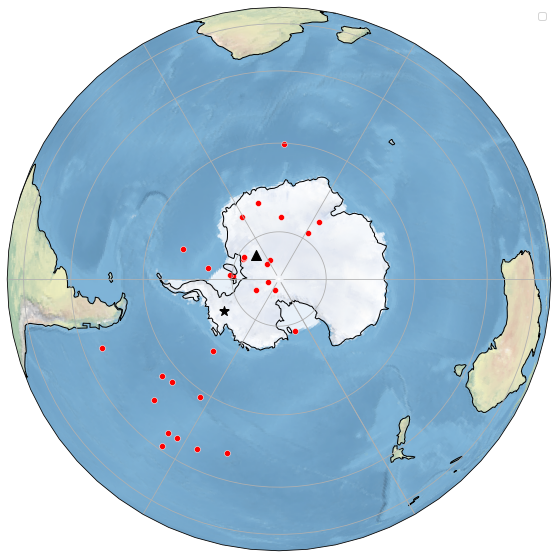

In [9]:
pole_id = 16

pole_vgps = poles_from_vgps[poles_from_vgps['pole_id'] == str(pole_id)]
vgps = df[df['pole_id'] == str(pole_id)]
pole_reference = df_NAM[df_NAM['pole_id'] == pole_id]

fig = plt.figure(figsize=(20,10))

proj = ccrs.Orthographic(30, -90)#Robinson()

ax = plt.axes(projection=proj)    
ax.coastlines()
ax.stock_img()
ax.gridlines()

sns.scatterplot(x = vgps['vgp_lon_SH'], y = vgps['vgp_lat_SH'],
                color = "red",                
                transform = ccrs.PlateCarree())

plt.scatter(x =pole_vgps['dec'], y = pole_vgps['inc'], marker ="*", 
            s = 100, color = "black", 
            transform = ccrs.PlateCarree())

plt.scatter(x =pole_reference['plon'], y = pole_reference['plat'], marker ="^", 
            s = 100, color = "black", 
            transform = ccrs.PlateCarree())

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels))
plt.show()

In [20]:
GCDs = []
ID = []
for _, i in poles_from_vgps.iterrows():
        
    pole_vgps = poles_from_vgps[poles_from_vgps['pole_id'] == str(i.pole_id)]
    pole_reference = df_NAM[df_NAM['pole_id'] == int(i.pole_id)]
    
    
    cart_ref = (spherical2cartesian([np.radians(pole_reference['plat'].values)[0],np.radians(pole_reference['plon'].values)[0]]))
    cart_vgps = (spherical2cartesian([np.radians(pole_vgps['inc'].values)[0], np.radians(pole_vgps['dec'].values)[0]]))
    
    GCDs.append(GCD_cartesian(cart_ref,cart_vgps)*180/np.pi)
    ID.append(int(i.pole_id))
    
dictionary = {'id':ID, 'gcds': GCDs}
df = pd.DataFrame(dictionary)

df
# fig = plt.figure(figsize=(15,5))
# plt.scatter(ID, GCDs)
# plt.show()

,id,gcds
0,1,NaN
1,10,0.514576
2,11,2.014055
3,12,0.940079
4,13,1.179240
5,14,1.540297
6,16,13.745146
7,17,17.882394
8,18,14.186749
9,19,13.146699


<AxesSubplot:xlabel='id', ylabel='gcds'>

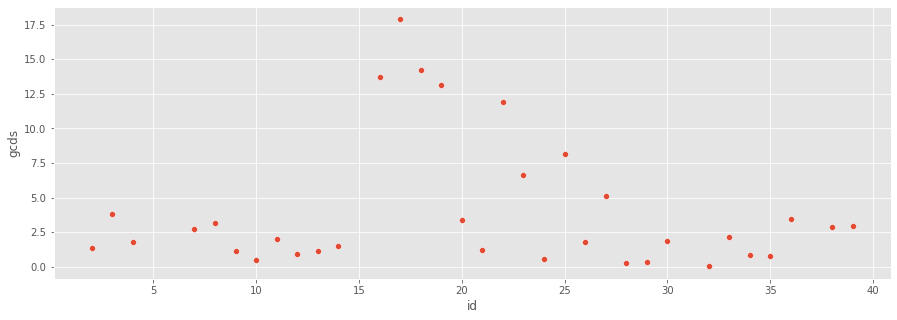

In [21]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(15,5))
sns.scatterplot(data=df, x="id", y='gcds')

In [95]:
df_tmp = pd.read_excel('C:\\Dropbox\\TRABAJOS\\2021_YOUNG_CEED\\Young_CEED_2.0/data/VGPs_NAM\\12.xlsx', skiprows = 5)
    
df_tmp.insert(0, 'pole_id', fname.replace('.', '/').replace('\\', '/').split('/')[-2])
df_tmp.insert(1, 'vgp_id', np.arange(1, df_tmp.shape[0] + 1))

# Calculates Pole statistics from vgps   
ipmag.vgp_calc(df_tmp, site_lon='slon', site_lat='slat', dec_tc='dec', inc_tc='inc')

#CRITERIA: if there is no slat/slon in the paper, we get as 'true' the VGP reported in the paper
df_tmp.vgp_lat.fillna(df_tmp.VGP_lat, inplace=True)
df_tmp.vgp_lon.fillna(df_tmp.VGP_lon, inplace=True)

df_tmp['vgp_lat_SH'] = np.where(df_tmp['vgp_lat'] > 0, -df_tmp['vgp_lat'], df_tmp['vgp_lat'])
df_tmp['vgp_lon_SH'] = np.where(df_tmp['vgp_lat'] > 0,(df_tmp['vgp_lon'] - 180.) % 360., df_tmp['vgp_lon'])

#CALCULATES FISHER STATISTICS FROM THE VGP LEVEL    
mean_tmp = ipmag.fisher_mean(dec = df_tmp['vgp_lon_SH'].tolist(),inc = df_tmp['vgp_lat_SH'].tolist())
mean_tmp['pole_id'] = fname.replace('.', '/').replace('\\', '/').split('/')[-2]

df_tmp['dec'][0:70]
#mean_tmp['dec']

0      20.8
1      11.0
2     332.4
3     351.1
4      26.8
5     350.1
6     324.9
7     183.2
8     352.4
9     330.1
10    341.3
11      8.5
12    342.1
13    355.0
14    352.9
15    347.0
16    177.8
17    173.2
18    188.2
19    208.3
20    169.3
21    172.5
22    179.5
23    357.0
24    212.9
25     98.3
26      0.2
27    163.2
28    203.1
29    181.8
30    197.1
31      0.0
32    164.3
33    166.4
34    187.4
35     37.9
36    352.3
37    333.2
38    213.4
39    181.9
40    188.1
41    180.6
42    185.6
43    177.6
44    162.2
45    182.0
46    185.5
47    335.6
48    176.0
49    150.7
50    131.2
51    345.8
52    180.4
53    200.3
54      NaN
Name: dec, dtype: float64

In [64]:
mean_tmp = ipmag.fisher_mean(dec = df_tmp['vgp_lon_SH'].tolist(),inc = df_tmp['vgp_lat_SH'].tolist())
mean_tmp

{'dec': nan,
 'inc': nan,
 'n': 70,
 'r': nan,
 'k': nan,
 'alpha95': nan,
 'csd': nan}

In [74]:
df_tmp['dec']

0       1.9
1     355.4
2     341.1
3     329.4
4     349.9
      ...  
65    162.7
66    358.0
67      8.6
68    159.9
69      NaN
Name: dec, Length: 70, dtype: float64